# Dataset

In [7]:
import sys

# add the parent directory to the path so we can import the module
sys.path.append("/data2/eranario/scratch/strawberry-yield-forecasting")

In [8]:
import torch
from src.dataset import StrawberryDataset

In [9]:
# create random seed
torch.manual_seed(42)

In [10]:
# device is cuda else cpu
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
path_to_counts = "/data2/eranario/data/Strawberry-Yield-Forecasting/"
path_to_weights = "/data2/eranario/data/Strawberry-Yield-Forecasting/weights/weights.csv"
n_seq = 5
seq_l = 3
n_folds = 2
k_fold = 2
use_weights = True
skip = ['flower'] # skip must be a list
time_int = False
dataset = StrawberryDataset(path_to_counts, path_to_weights, k_fold=k_fold,
                            n_seq=n_seq, seq_l=seq_l, n_folds=n_folds, use_weights=use_weights, 
                            skip=skip, time_int=time_int)

In [12]:
# Check date parsing
months, days, years = dataset.months, dataset.days, dataset.years
print("\nParsed Dates:")
print("Months:", months)
print("Days:", days)
print("Years:", years)


X_data, y_data = dataset.fnX, dataset.fny
print("\nOrganized Data Shapes:")
print("X_data shape:", X_data.shape)  # Expected: (num_samples, num_features)
print("y_data shape:", y_data.shape)  # Expected: (num_samples, num_labels)

# Display sample data from X and y
print("\nSample X_data:", X_data[0][:10])  # Display first 10 features of first sample
print("Sample y_data:", y_data[0])         # Display first sample of y_data

print("\nDataset length (number of samples):", len(dataset))

X_sample, y_sample = dataset[0]
print("\nSample from __getitem__:")
print("X_sample:", X_sample[:10])  # Display first 10 features of X_sample
print("y_sample:", y_sample)


Parsed Dates:
Months: ['06', '06', '07', '07', '07', '07', '07', '07', '08', '08', '08', '08', '08', '09', '09', '09']
Days: ['17', '28', '05', '08', '15', '19', '26', '29', '02', '05', '09', '12', '29', '01', '20', '22']
Years: ['2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022']

Organized Data Shapes:
X_data shape: (495, 3, 5)
y_data shape: (495, 1)

Sample X_data: [[0.25957873 0.08863333 0.         0.         1.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.3789208  0.         0.72231454]]
Sample y_data: [0.33320494]

Dataset length (number of samples): 495

Sample from __getitem__:
X_sample: tensor([[0.2596, 0.0886, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3789, 0.0000, 0.7223]])
y_sample: tensor([0.3332])


# Dataloader

In [13]:
import torch
from torch.utils.data import DataLoader

In [14]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [15]:
len(train_loader), len(val_loader)

(93, 31)

In [16]:
# try to get a batch of data
for i, (X_batch, y_batch) in enumerate(train_loader):
    print("\nBatch", i)
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("X_batch:", X_batch)
    print("y_batch:", y_batch)
    
    # print number of columns in X_batch
    print("Number of columns in X_batch:", X_batch.shape[1])
    
    # print number of rows in X_batch
    print("Number of rows in X_batch:", X_batch.shape[0])
    
    # print length in third dimension of X_batch
    print("Length in third dimension of X_batch:", X_batch.shape[2])
    
    # get last class values (from third dimension) of X_batch
    last_class_values = X_batch[:, :, -1]
    print("Last class values of X_batch:", last_class_values)
    break


Batch 0
X_batch shape: torch.Size([4, 3, 5])
y_batch shape: torch.Size([4, 1])
X_batch: tensor([[[0.0484, 0.6756, 0.0000, 0.0000, 0.6802],
         [0.0000, 0.5423, 0.1184, 0.0000, 0.8787],
         [0.0000, 0.0633, 0.4654, 0.0000, 0.7910]],

        [[0.0589, 0.5014, 0.0000, 0.0000, 0.8609],
         [0.0000, 0.4376, 0.2047, 0.0000, 0.7450],
         [0.0000, 0.0000, 0.3846, 0.0000, 0.5643]],

        [[0.0147, 0.0228, 0.0000, 0.0000, 0.1634],
         [0.0000, 0.0975, 0.0366, 0.0000, 0.1823],
         [0.0000, 0.0000, 0.0470, 0.0000, 0.0984]],

        [[0.1825, 0.3391, 0.0000, 0.0000, 0.8919],
         [0.0000, 0.0228, 0.0797, 0.0000, 0.2308],
         [0.0000, 0.1146, 0.2575, 0.0000, 0.3773]]])
y_batch: tensor([[0.6626],
        [0.6784],
        [0.2501],
        [0.5292]])
Number of columns in X_batch: 3
Number of rows in X_batch: 4
Length in third dimension of X_batch: 5
Last class values of X_batch: tensor([[0.6802, 0.8787, 0.7910],
        [0.8609, 0.7450, 0.5643],
        [0

# Training

In [17]:
from torch.optim import Adam
from torch.nn import MSELoss
from src.model import LSTMModel

import matplotlib.pyplot as plt

In [18]:
def train_lstm_model(model, train_loader, val_loader, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    best_val_loss = float("inf")
    best_model = None
    
    train_losses = []  # To store train loss for each epoch
    val_losses = []    # To store validation loss for each epoch
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)  # Append to train losses
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Append to validation losses
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
    
    # Load best model before returning
    model.load_state_dict(best_model)
    
    # Plot training and validation loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return model


In [19]:
input_dim = dataset.samples_dim[2]
epochs = 50
learning_rate = 0.0001

model = LSTMModel(input_dim=input_dim)

Epoch 1/50, Train Loss: 0.4216, Val Loss: 0.3391
Epoch 2/50, Train Loss: 0.3366, Val Loss: 0.2198
Epoch 3/50, Train Loss: 0.1251, Val Loss: 0.0385
Epoch 4/50, Train Loss: 0.0357, Val Loss: 0.0386
Epoch 5/50, Train Loss: 0.0349, Val Loss: 0.0374
Epoch 6/50, Train Loss: 0.0340, Val Loss: 0.0360
Epoch 7/50, Train Loss: 0.0330, Val Loss: 0.0344
Epoch 8/50, Train Loss: 0.0317, Val Loss: 0.0324
Epoch 9/50, Train Loss: 0.0302, Val Loss: 0.0303
Epoch 10/50, Train Loss: 0.0285, Val Loss: 0.0279
Epoch 11/50, Train Loss: 0.0268, Val Loss: 0.0255
Epoch 12/50, Train Loss: 0.0250, Val Loss: 0.0232
Epoch 13/50, Train Loss: 0.0234, Val Loss: 0.0213
Epoch 14/50, Train Loss: 0.0221, Val Loss: 0.0199
Epoch 15/50, Train Loss: 0.0211, Val Loss: 0.0189
Epoch 16/50, Train Loss: 0.0204, Val Loss: 0.0182
Epoch 17/50, Train Loss: 0.0200, Val Loss: 0.0177
Epoch 18/50, Train Loss: 0.0196, Val Loss: 0.0174
Epoch 19/50, Train Loss: 0.0194, Val Loss: 0.0172
Epoch 20/50, Train Loss: 0.0192, Val Loss: 0.0170
Epoch 21/

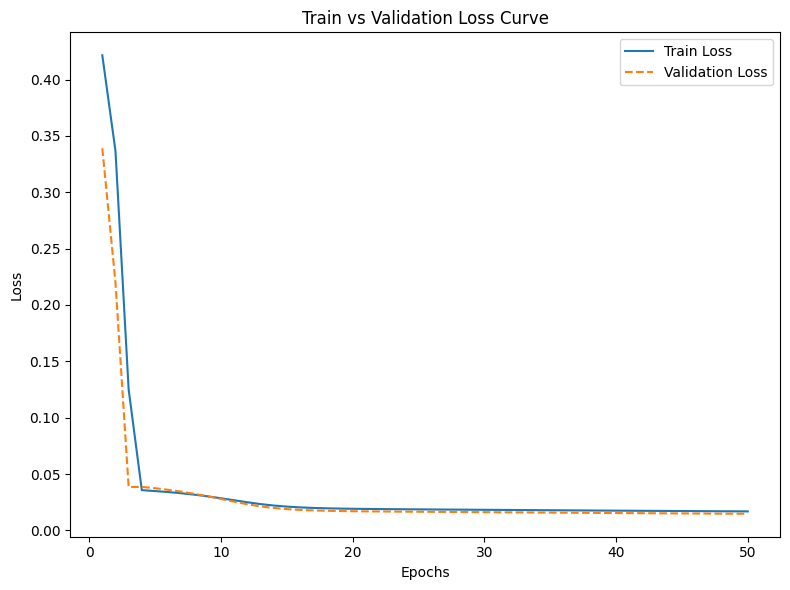

In [20]:
trained_model = train_lstm_model(model, train_loader, val_loader, epochs, learning_rate)

# Test

In [21]:
import numpy as np

In [22]:
def evaluate_test_set(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_values = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())  # Store predictions
            true_values.append(y_batch.cpu().numpy())  # Store true labels
    
    # Concatenate the results into single arrays
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    
    return predictions, true_values


In [23]:
dataset.mode = 'test'

test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# check first batch
X_batch, y_batch = next(iter(test_loader))
print("\nSample from test_loader:")
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)
print("X_batch:", X_batch)


Sample from test_loader:
X_batch shape: torch.Size([1, 3, 5])
y_batch shape: torch.Size([1, 1])
X_batch: tensor([[[0.0000, 0.2408, 0.0580, 0.0000, 0.3649],
         [0.0000, 0.0774, 0.1976, 0.0000, 0.7133],
         [0.0000, 0.0260, 0.2823, 0.0000, 0.3062]]])


In [24]:
predictions, true_values = evaluate_test_set(trained_model, test_loader, device)

R^2: 0.4207 RMSE: 0.1715


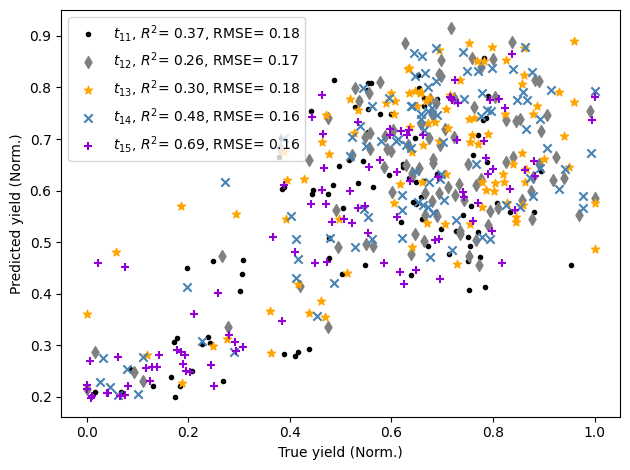

In [25]:
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

# change true and predicted from (495, 1) to (5. 99)
true_values_reshaped = true_values.reshape(n_seq, -1)
predictions_reshaped = predictions.reshape(n_seq, -1)

scatter_marker = ['.','d','*','x','+','o','.','x','d','*']
scatter_color = ['black','gray','orange','steelblue','darkviolet','blue','pink','blue','pink','coral']

time_folds = [[4, 5, 6, 7, 8], [11, 12, 13, 14, 15]]

plt.figure()
r2_list = []
rmse_list = []

for time in range(n_seq):
    slope, intercept, r_value, p_value, std_err = linregress(true_values_reshaped[time, :], predictions_reshaped[time, :])
    r2 = r_value ** 2
    rmse = np.sqrt(mean_squared_error(true_values_reshaped[time], predictions_reshaped[time]))
    
    label = str(time_folds[k_fold-1][time])
    plt.scatter(true_values_reshaped[time, :], predictions_reshaped[time, :], marker = scatter_marker[time], color=scatter_color[time], label = f'$t_{{{label}}}$, $R^2$= {r2:.2f}, RMSE= {rmse:.2f}')
    r2_list.append(r2)
    rmse_list.append(rmse)

print(f"R^2: {np.mean(r2_list):.4f}", f"RMSE: {np.mean(rmse_list):.4f}")
plt.xlabel('True yield (Norm.)')
plt.ylabel('Predicted yield (Norm.)')
plt.legend()
plt.tight_layout()
plt.show()

R^2: 0.4207 RMSE: 29.5404


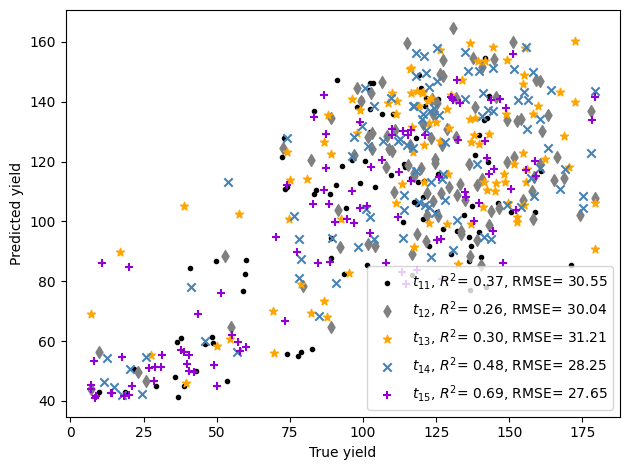

In [26]:
# Access the scaler
y_scaler = dataset.y_scaler

# Determine the number of expected features
expected_features = y_scaler.min_.shape[0]

# Pad true values and predictions
true_values_padded = np.zeros((true_values.shape[0], expected_features))
predictions_padded = np.zeros((predictions.shape[0], expected_features))

# Assign the actual values to the appropriate column (e.g., first column)
true_values_padded[:, 0] = true_values.flatten()
predictions_padded[:, 0] = predictions.flatten()

# Unnormalize and extract the relevant column
true_values_unnormalized = y_scaler.inverse_transform(true_values_padded)[:, 0]
predictions_unnormalized = y_scaler.inverse_transform(predictions_padded)[:, 0]

# Reshape for evaluation
true_values_reshaped_final = true_values_unnormalized.reshape(n_seq, -1)
predictions_reshaped_final = predictions_unnormalized.reshape(n_seq, -1)

scatter_marker = ['.','d','*','x','+','o','.','x','d','*']
scatter_color = ['black','gray','orange','steelblue','darkviolet','blue','pink','blue','pink','coral']

time_folds = [[4, 5, 6, 7, 8], [11, 12, 13, 14, 15]]

plt.figure()
r2_list = []
rmse_list = []

for time in range(n_seq):
    slope, intercept, r_value, p_value, std_err = linregress(
        true_values_reshaped_final[time, :], predictions_reshaped_final[time, :]
    )
    r2 = r_value ** 2
    rmse = np.sqrt(mean_squared_error(
        true_values_reshaped_final[time], predictions_reshaped_final[time]
    ))

    label = str(time_folds[k_fold-1][time])
    plt.scatter(
        true_values_reshaped_final[time, :], predictions_reshaped_final[time, :],
        marker=scatter_marker[time], color=scatter_color[time],
        label=f'$t_{{{label}}}$, $R^2$= {r2:.2f}, RMSE= {rmse:.2f}'
    )
    r2_list.append(r2)
    rmse_list.append(rmse)

print(f"R^2: {np.mean(r2_list):.4f}", f"RMSE: {np.mean(rmse_list):.4f}")
plt.xlabel('True yield')
plt.ylabel('Predicted yield')
plt.legend()
plt.tight_layout()
plt.show()
